In [1]:
import os
from glob import glob
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.utils.data as data
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

import cv2
import csv
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

from scipy.spatial.transform import Rotation as R
import open3d as o3d
from pose_metric import add_ac

# Hyperparameter

In [2]:
print('Num_GPU :', torch.cuda.device_count())

no_cuda = False
use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
Tensor = torch.cuda.FloatTensor if use_cuda else torch.Tensor

params = {
    'batch_size':80 * torch.cuda.device_count(),
    'test_batch_size':80 * torch.cuda.device_count(),
    'input_size':299,
    'resize_scale':330,
    'crop_size':299,
    'fliplr':False,
    'threshold':0.5,
    #model params
    'ngf':64,
    'ndf':64,
    'epoch_count':1,
    'epochs':500,
    'log_interval':4,
    'lr':0.0002,
    'dataroot':'C:/Users/IVCL/Desktop/crane',
}

Num_GPU : 2


# Model

In [3]:
model = models.inception_v3(pretrained=True)
model.aux_logits=False
num_features = model.fc.in_features
features = list(model.fc.children())[:-1]
features.extend([nn.Linear(num_features, 4)])
features.extend([nn.Tanh()])
model.fc = nn.Sequential(*features)

model = nn.DataParallel(model)
model.to(device)

DataParallel(
  (module): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4a_3x3): BasicConv2d(
      (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    

# Preprocess

In [4]:
train_image_paths = glob(params['dataroot'] + '/image_coco_512_aug/*.png')
test_image_paths = glob(params['dataroot'] + '/real_image_crop/*.png')

train_pose_list = []
f = open("./quat_blender.csv", "r")
lines = csv.reader(f)
for line in lines:
    train_pose_list.append(line)
f.close()

train_pose_list_10 = []
for i in range(0,10):
    train_pose_list_10 = train_pose_list_10 + train_pose_list

train_pose_list_10 = np.array([list(map(float, train_pose_list_10[i])) for i in range(0,len(train_pose_list_10))])

test_pose_list = []
f = open("./quat_real.csv", "r")
lines = csv.reader(f)
for line in lines:
    test_pose_list.append(line)
f.close()
test_pose_list = np.array([list(map(float, test_pose_list[i])) for i in range(0,len(test_pose_list))])

In [5]:
class DatasetFromFolder(data.Dataset):
    def __init__(self, image_dir, pose, transform=None, resize_scale=None, crop_size=None, fliplr=False):
        super(DatasetFromFolder, self).__init__()
        self.image_path = image_dir
        self.pose_list = pose
        
        self.transform = transform
        
        self.resize_scale = resize_scale
        self.crop_size = crop_size
        self.fliplr = fliplr

    def __getitem__(self, index):
        # Load Image
        img_fn = self.image_path[index]
        img = Image.open(img_fn).convert('RGB')
        pose = self.pose_list[index]
        
        seed = random.randint(1, 1000)
        random.seed(seed)
                          
        # preprocessing
        if self.resize_scale:
            img = img.resize((self.resize_scale, self.resize_scale), Image.BILINEAR)
            
        if self.crop_size:
            x = random.randint(0, self.resize_scale - self.crop_size + 1)
            y = random.randint(0, self.resize_scale - self.crop_size + 1)
            img = img.crop((x, y, x + self.crop_size, y + self.crop_size))
            
        if self.fliplr:
            if random.random() < 0.5:
                img = img.transpose(Image.FLIP_LEFT_RIGHT)
        
        if self.transform is not None:
            img = self.transform(img)
        
        return img, pose

    def __len__(self):
        return len(self.image_path)

In [6]:
transform = transforms.Compose([
    transforms.Resize(size=(params['input_size'], params['input_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

train_data = DatasetFromFolder(train_image_paths, train_pose_list_10, transform=transform,
                                resize_scale=params['resize_scale'], crop_size=params['crop_size'], fliplr=params['fliplr'])
train_data_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=params['batch_size'], shuffle=True)

test_data = DatasetFromFolder(test_image_paths, test_pose_list, transform=transform,
                             resize_scale=params['input_size'])
test_data_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=params['test_batch_size'], shuffle=False)

In [7]:
for i, (data, pose) in enumerate(train_data_loader):
    if i == 0:
        print(data[0].shape, pose[0])
        break

torch.Size([3, 299, 299]) tensor([ 0.2109,  0.7957, -0.3645,  0.4354], dtype=torch.float64)


pose : [ 0.07363054  0.84708639 -0.51951067  0.08233768]


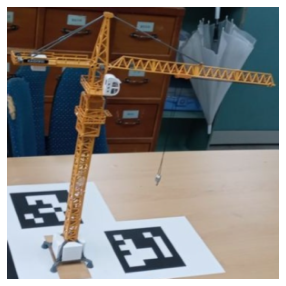

In [8]:
# Get specific test images
test_image, test_pose = test_data.__getitem__(15) # Convert to 4d tensor (BxNxHxW)
test_image = test_image.unsqueeze(0)

test_data_image = ((test_image - test_image.min()) / (test_image.max() - test_image.min()))

plt.figure(figsize=(5,5))
plt.imshow(test_data_image[0].permute(1,2,0))
plt.axis('off')
print("pose :",test_pose)

# Optimization

In [9]:
def mse_loss(input, target):
    loss = ((input-target)**2).mean()
    return loss

# setup optimizer
optimizer = optim.Adam(model.parameters(), lr=params['lr'])

# Visualization

In [10]:
def visualization(model, test_path, test_pose):
    model.eval()
    model.to(device)
    transform = transforms.Compose([
            transforms.Resize(size=(params['input_size'], params['input_size'])),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])     

    image = Image.open(test_path).convert("RGB")
    image = transform(image).unsqueeze_(0)
    pose = model(image)
  
    test_image = plt.imread(test_path)
    
    plt.figure(figsize=(10,10))      
    plt.subplot(1, 3, 1)
    plt.title("Ground Truth(Pose): {}\nPredicted Pose: {}".format(test_pose, pose[0].cpu().detach().numpy()))
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(test_image)
    plt.axis('off')

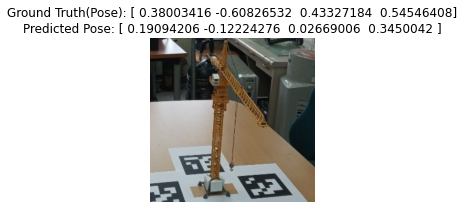

In [11]:
test_path = 'C:/Users/IVCL/Desktop/crane/real_image_crop/creal_0065.png'
visualization(model, test_path, test_pose_list[64])

# Training

In [12]:
checkpoint_path = './checkpoints/pose_inceptionv3'

In [13]:
train_avg_pose_losses = []
val_avg_pose_losses = []

for epoch in range(params['epoch_count'], params['epochs'] + 1):
    # train
    model.to(device).train()
    cut_num = 20
    
    train_pose_losses = []
    val_pose_losses = []
    
    for iteration, (batch) in enumerate(train_data_loader):
        
        image, pose = batch[0].to(device), batch[1].to(device)
        pre_pose = model(image)
        optimizer.zero_grad()
         
        # Pose loss
        loss_pose = mse_loss(pre_pose, pose)
        
        loss_pose.backward()
        optimizer.step()
        
        # loss values
        train_pose_losses.append(loss_pose.item())

        if iteration % params['log_interval'] == 0:
            print("===> Epoch[{}/{}]({}/{}): Loss_Pose: {:.4f}".format(
                epoch, params['epochs'],iteration, cut_num, loss_pose.item()))
        
        if iteration == cut_num:
            break
        
    # avg loss values for plot
    train_avg_pose_loss = torch.mean(torch.FloatTensor(train_pose_losses))   
    train_avg_pose_losses.append(train_avg_pose_loss.item())
    

    
    model.to(device).eval()
    
    with torch.no_grad():
        for iteration, (batch) in enumerate(test_data_loader):
            
            image, pose = batch[0].to(device), batch[1].to(device)
            pre_pose = model(image)

            # Pose loss
            loss_pose = mse_loss(pre_pose, pose)

            val_pose_losses.append(loss_pose.item())
    
    # avg loss values for plot
    val_avg_pose_loss = torch.mean(torch.FloatTensor(val_pose_losses))
    val_avg_pose_losses.append(val_avg_pose_loss.item())
    
    print("Val_Loss_Pose: {:.4f}".format(val_avg_pose_loss.item()))

    # Save weight
    if epoch % 1 == 0:
        torch.save(model.state_dict(), checkpoint_path+'/model-%s.pt'%epoch)

C:\Users\IVCL\Miniconda3\envs\tc150\lib\site-packages\torch\cuda\nccl.py:24: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


===> Epoch[1/500](0/20): Loss_Pose: 0.3866
===> Epoch[1/500](4/20): Loss_Pose: 0.1989
===> Epoch[1/500](8/20): Loss_Pose: 0.2239
===> Epoch[1/500](12/20): Loss_Pose: 0.1626
===> Epoch[1/500](16/20): Loss_Pose: 0.1705
===> Epoch[1/500](20/20): Loss_Pose: 0.1374
Val_Loss_Pose: 0.1101
===> Epoch[2/500](0/20): Loss_Pose: 0.1323
===> Epoch[2/500](4/20): Loss_Pose: 0.1329
===> Epoch[2/500](8/20): Loss_Pose: 0.1004
===> Epoch[2/500](12/20): Loss_Pose: 0.0977
===> Epoch[2/500](16/20): Loss_Pose: 0.0871
===> Epoch[2/500](20/20): Loss_Pose: 0.0814
Val_Loss_Pose: 0.0643
===> Epoch[3/500](0/20): Loss_Pose: 0.0784
===> Epoch[3/500](4/20): Loss_Pose: 0.0540
===> Epoch[3/500](8/20): Loss_Pose: 0.0546
===> Epoch[3/500](12/20): Loss_Pose: 0.0537
===> Epoch[3/500](16/20): Loss_Pose: 0.0669
===> Epoch[3/500](20/20): Loss_Pose: 0.0561
Val_Loss_Pose: 0.0626
===> Epoch[4/500](0/20): Loss_Pose: 0.0300
===> Epoch[4/500](4/20): Loss_Pose: 0.0496
===> Epoch[4/500](8/20): Loss_Pose: 0.0341
===> Epoch[4/500](12/2

===> Epoch[29/500](16/20): Loss_Pose: 0.0060
===> Epoch[29/500](20/20): Loss_Pose: 0.0128
Val_Loss_Pose: 0.0037
===> Epoch[30/500](0/20): Loss_Pose: 0.0032
===> Epoch[30/500](4/20): Loss_Pose: 0.0036
===> Epoch[30/500](8/20): Loss_Pose: 0.0044
===> Epoch[30/500](12/20): Loss_Pose: 0.0048
===> Epoch[30/500](16/20): Loss_Pose: 0.0030
===> Epoch[30/500](20/20): Loss_Pose: 0.0043
Val_Loss_Pose: 0.0094
===> Epoch[31/500](0/20): Loss_Pose: 0.0102
===> Epoch[31/500](4/20): Loss_Pose: 0.0042
===> Epoch[31/500](8/20): Loss_Pose: 0.0084
===> Epoch[31/500](12/20): Loss_Pose: 0.0033
===> Epoch[31/500](16/20): Loss_Pose: 0.0068
===> Epoch[31/500](20/20): Loss_Pose: 0.0030
Val_Loss_Pose: 0.0028
===> Epoch[32/500](0/20): Loss_Pose: 0.0033
===> Epoch[32/500](4/20): Loss_Pose: 0.0025
===> Epoch[32/500](8/20): Loss_Pose: 0.0030
===> Epoch[32/500](12/20): Loss_Pose: 0.0022
===> Epoch[32/500](16/20): Loss_Pose: 0.0025
===> Epoch[32/500](20/20): Loss_Pose: 0.0046
Val_Loss_Pose: 0.0136
===> Epoch[33/500](0/

===> Epoch[58/500](0/20): Loss_Pose: 0.0029
===> Epoch[58/500](4/20): Loss_Pose: 0.0020
===> Epoch[58/500](8/20): Loss_Pose: 0.0023
===> Epoch[58/500](12/20): Loss_Pose: 0.0046
===> Epoch[58/500](16/20): Loss_Pose: 0.0026
===> Epoch[58/500](20/20): Loss_Pose: 0.0128
Val_Loss_Pose: 0.0021
===> Epoch[59/500](0/20): Loss_Pose: 0.0019
===> Epoch[59/500](4/20): Loss_Pose: 0.0022
===> Epoch[59/500](8/20): Loss_Pose: 0.0019
===> Epoch[59/500](12/20): Loss_Pose: 0.0059
===> Epoch[59/500](16/20): Loss_Pose: 0.0019
===> Epoch[59/500](20/20): Loss_Pose: 0.0020
Val_Loss_Pose: 0.0098
===> Epoch[60/500](0/20): Loss_Pose: 0.0019
===> Epoch[60/500](4/20): Loss_Pose: 0.0020
===> Epoch[60/500](8/20): Loss_Pose: 0.0023
===> Epoch[60/500](12/20): Loss_Pose: 0.0024
===> Epoch[60/500](16/20): Loss_Pose: 0.0016
===> Epoch[60/500](20/20): Loss_Pose: 0.0016
Val_Loss_Pose: 0.0067
===> Epoch[61/500](0/20): Loss_Pose: 0.0021
===> Epoch[61/500](4/20): Loss_Pose: 0.0024
===> Epoch[61/500](8/20): Loss_Pose: 0.0022
=

===> Epoch[86/500](12/20): Loss_Pose: 0.0014
===> Epoch[86/500](16/20): Loss_Pose: 0.0015
===> Epoch[86/500](20/20): Loss_Pose: 0.0017
Val_Loss_Pose: 0.0113
===> Epoch[87/500](0/20): Loss_Pose: 0.0014
===> Epoch[87/500](4/20): Loss_Pose: 0.0017
===> Epoch[87/500](8/20): Loss_Pose: 0.0023
===> Epoch[87/500](12/20): Loss_Pose: 0.0016
===> Epoch[87/500](16/20): Loss_Pose: 0.0015
===> Epoch[87/500](20/20): Loss_Pose: 0.0018
Val_Loss_Pose: 0.0232
===> Epoch[88/500](0/20): Loss_Pose: 0.0038
===> Epoch[88/500](4/20): Loss_Pose: 0.0020
===> Epoch[88/500](8/20): Loss_Pose: 0.0015
===> Epoch[88/500](12/20): Loss_Pose: 0.0017
===> Epoch[88/500](16/20): Loss_Pose: 0.0018
===> Epoch[88/500](20/20): Loss_Pose: 0.0071
Val_Loss_Pose: 0.0169
===> Epoch[89/500](0/20): Loss_Pose: 0.0096
===> Epoch[89/500](4/20): Loss_Pose: 0.0023
===> Epoch[89/500](8/20): Loss_Pose: 0.0022
===> Epoch[89/500](12/20): Loss_Pose: 0.0026
===> Epoch[89/500](16/20): Loss_Pose: 0.0018
===> Epoch[89/500](20/20): Loss_Pose: 0.001

===> Epoch[114/500](16/20): Loss_Pose: 0.0011
===> Epoch[114/500](20/20): Loss_Pose: 0.0013
Val_Loss_Pose: 0.0114
===> Epoch[115/500](0/20): Loss_Pose: 0.0012
===> Epoch[115/500](4/20): Loss_Pose: 0.0065
===> Epoch[115/500](8/20): Loss_Pose: 0.0012
===> Epoch[115/500](12/20): Loss_Pose: 0.0013
===> Epoch[115/500](16/20): Loss_Pose: 0.0012
===> Epoch[115/500](20/20): Loss_Pose: 0.0022
Val_Loss_Pose: 0.0122
===> Epoch[116/500](0/20): Loss_Pose: 0.0014
===> Epoch[116/500](4/20): Loss_Pose: 0.0010
===> Epoch[116/500](8/20): Loss_Pose: 0.0020
===> Epoch[116/500](12/20): Loss_Pose: 0.0011
===> Epoch[116/500](16/20): Loss_Pose: 0.0015
===> Epoch[116/500](20/20): Loss_Pose: 0.0011
Val_Loss_Pose: 0.0078
===> Epoch[117/500](0/20): Loss_Pose: 0.0012
===> Epoch[117/500](4/20): Loss_Pose: 0.0013
===> Epoch[117/500](8/20): Loss_Pose: 0.0014
===> Epoch[117/500](12/20): Loss_Pose: 0.0022
===> Epoch[117/500](16/20): Loss_Pose: 0.0039
===> Epoch[117/500](20/20): Loss_Pose: 0.0010
Val_Loss_Pose: 0.0048
=

===> Epoch[142/500](12/20): Loss_Pose: 0.0012
===> Epoch[142/500](16/20): Loss_Pose: 0.0010
===> Epoch[142/500](20/20): Loss_Pose: 0.0011
Val_Loss_Pose: 0.0192
===> Epoch[143/500](0/20): Loss_Pose: 0.0029
===> Epoch[143/500](4/20): Loss_Pose: 0.0012
===> Epoch[143/500](8/20): Loss_Pose: 0.0013
===> Epoch[143/500](12/20): Loss_Pose: 0.0013
===> Epoch[143/500](16/20): Loss_Pose: 0.0012
===> Epoch[143/500](20/20): Loss_Pose: 0.0011
Val_Loss_Pose: 0.0183
===> Epoch[144/500](0/20): Loss_Pose: 0.0011
===> Epoch[144/500](4/20): Loss_Pose: 0.0010
===> Epoch[144/500](8/20): Loss_Pose: 0.0010
===> Epoch[144/500](12/20): Loss_Pose: 0.0012
===> Epoch[144/500](16/20): Loss_Pose: 0.0011
===> Epoch[144/500](20/20): Loss_Pose: 0.0015
Val_Loss_Pose: 0.0165
===> Epoch[145/500](0/20): Loss_Pose: 0.0036
===> Epoch[145/500](4/20): Loss_Pose: 0.0010
===> Epoch[145/500](8/20): Loss_Pose: 0.0010
===> Epoch[145/500](12/20): Loss_Pose: 0.0047
===> Epoch[145/500](16/20): Loss_Pose: 0.0013
===> Epoch[145/500](20/

===> Epoch[170/500](8/20): Loss_Pose: 0.0009
===> Epoch[170/500](12/20): Loss_Pose: 0.0009
===> Epoch[170/500](16/20): Loss_Pose: 0.0009
===> Epoch[170/500](20/20): Loss_Pose: 0.0009
Val_Loss_Pose: 0.0122
===> Epoch[171/500](0/20): Loss_Pose: 0.0014
===> Epoch[171/500](4/20): Loss_Pose: 0.0008
===> Epoch[171/500](8/20): Loss_Pose: 0.0009
===> Epoch[171/500](12/20): Loss_Pose: 0.0011
===> Epoch[171/500](16/20): Loss_Pose: 0.0010
===> Epoch[171/500](20/20): Loss_Pose: 0.0008
Val_Loss_Pose: 0.0152
===> Epoch[172/500](0/20): Loss_Pose: 0.0010
===> Epoch[172/500](4/20): Loss_Pose: 0.0012
===> Epoch[172/500](8/20): Loss_Pose: 0.0010
===> Epoch[172/500](12/20): Loss_Pose: 0.0011
===> Epoch[172/500](16/20): Loss_Pose: 0.0010
===> Epoch[172/500](20/20): Loss_Pose: 0.0008
Val_Loss_Pose: 0.0136
===> Epoch[173/500](0/20): Loss_Pose: 0.0009
===> Epoch[173/500](4/20): Loss_Pose: 0.0010
===> Epoch[173/500](8/20): Loss_Pose: 0.0008
===> Epoch[173/500](12/20): Loss_Pose: 0.0010
===> Epoch[173/500](16/2

===> Epoch[198/500](4/20): Loss_Pose: 0.0019
===> Epoch[198/500](8/20): Loss_Pose: 0.0013
===> Epoch[198/500](12/20): Loss_Pose: 0.0064
===> Epoch[198/500](16/20): Loss_Pose: 0.0065
===> Epoch[198/500](20/20): Loss_Pose: 0.0020
Val_Loss_Pose: 0.0275
===> Epoch[199/500](0/20): Loss_Pose: 0.0016
===> Epoch[199/500](4/20): Loss_Pose: 0.0016
===> Epoch[199/500](8/20): Loss_Pose: 0.0017
===> Epoch[199/500](12/20): Loss_Pose: 0.0020
===> Epoch[199/500](16/20): Loss_Pose: 0.0132
===> Epoch[199/500](20/20): Loss_Pose: 0.0024
Val_Loss_Pose: 0.0230
===> Epoch[200/500](0/20): Loss_Pose: 0.0034
===> Epoch[200/500](4/20): Loss_Pose: 0.0068
===> Epoch[200/500](8/20): Loss_Pose: 0.0016
===> Epoch[200/500](12/20): Loss_Pose: 0.0013
===> Epoch[200/500](16/20): Loss_Pose: 0.0013
===> Epoch[200/500](20/20): Loss_Pose: 0.0014
Val_Loss_Pose: 0.0120
===> Epoch[201/500](0/20): Loss_Pose: 0.0016
===> Epoch[201/500](4/20): Loss_Pose: 0.0017
===> Epoch[201/500](8/20): Loss_Pose: 0.0042
===> Epoch[201/500](12/20

Val_Loss_Pose: 0.0038
===> Epoch[226/500](0/20): Loss_Pose: 0.0031
===> Epoch[226/500](4/20): Loss_Pose: 0.0009
===> Epoch[226/500](8/20): Loss_Pose: 0.0010
===> Epoch[226/500](12/20): Loss_Pose: 0.0009
===> Epoch[226/500](16/20): Loss_Pose: 0.0072
===> Epoch[226/500](20/20): Loss_Pose: 0.0012
Val_Loss_Pose: 0.0169
===> Epoch[227/500](0/20): Loss_Pose: 0.0012
===> Epoch[227/500](4/20): Loss_Pose: 0.0012
===> Epoch[227/500](8/20): Loss_Pose: 0.0009
===> Epoch[227/500](12/20): Loss_Pose: 0.0010
===> Epoch[227/500](16/20): Loss_Pose: 0.0040
===> Epoch[227/500](20/20): Loss_Pose: 0.0011
Val_Loss_Pose: 0.0182
===> Epoch[228/500](0/20): Loss_Pose: 0.0014
===> Epoch[228/500](4/20): Loss_Pose: 0.0010
===> Epoch[228/500](8/20): Loss_Pose: 0.0017
===> Epoch[228/500](12/20): Loss_Pose: 0.0014
===> Epoch[228/500](16/20): Loss_Pose: 0.0015
===> Epoch[228/500](20/20): Loss_Pose: 0.0011
Val_Loss_Pose: 0.0073
===> Epoch[229/500](0/20): Loss_Pose: 0.0016
===> Epoch[229/500](4/20): Loss_Pose: 0.0010
===

===> Epoch[253/500](20/20): Loss_Pose: 0.0010
Val_Loss_Pose: 0.0314
===> Epoch[254/500](0/20): Loss_Pose: 0.0010
===> Epoch[254/500](4/20): Loss_Pose: 0.0011
===> Epoch[254/500](8/20): Loss_Pose: 0.0037
===> Epoch[254/500](12/20): Loss_Pose: 0.0008
===> Epoch[254/500](16/20): Loss_Pose: 0.0050
===> Epoch[254/500](20/20): Loss_Pose: 0.0009
Val_Loss_Pose: 0.0114
===> Epoch[255/500](0/20): Loss_Pose: 0.0008
===> Epoch[255/500](4/20): Loss_Pose: 0.0008
===> Epoch[255/500](8/20): Loss_Pose: 0.0008
===> Epoch[255/500](12/20): Loss_Pose: 0.0008
===> Epoch[255/500](16/20): Loss_Pose: 0.0010
===> Epoch[255/500](20/20): Loss_Pose: 0.0006
Val_Loss_Pose: 0.0067
===> Epoch[256/500](0/20): Loss_Pose: 0.0067
===> Epoch[256/500](4/20): Loss_Pose: 0.0009
===> Epoch[256/500](8/20): Loss_Pose: 0.0008
===> Epoch[256/500](12/20): Loss_Pose: 0.0012
===> Epoch[256/500](16/20): Loss_Pose: 0.0006
===> Epoch[256/500](20/20): Loss_Pose: 0.0009
Val_Loss_Pose: 0.0026
===> Epoch[257/500](0/20): Loss_Pose: 0.0008
==

===> Epoch[281/500](16/20): Loss_Pose: 0.0007
===> Epoch[281/500](20/20): Loss_Pose: 0.0006
Val_Loss_Pose: 0.0200
===> Epoch[282/500](0/20): Loss_Pose: 0.0006
===> Epoch[282/500](4/20): Loss_Pose: 0.0015
===> Epoch[282/500](8/20): Loss_Pose: 0.0006
===> Epoch[282/500](12/20): Loss_Pose: 0.0008
===> Epoch[282/500](16/20): Loss_Pose: 0.0007
===> Epoch[282/500](20/20): Loss_Pose: 0.0010
Val_Loss_Pose: 0.0150
===> Epoch[283/500](0/20): Loss_Pose: 0.0008
===> Epoch[283/500](4/20): Loss_Pose: 0.0016
===> Epoch[283/500](8/20): Loss_Pose: 0.0011
===> Epoch[283/500](12/20): Loss_Pose: 0.0037
===> Epoch[283/500](16/20): Loss_Pose: 0.0009
===> Epoch[283/500](20/20): Loss_Pose: 0.0011
Val_Loss_Pose: 0.0186
===> Epoch[284/500](0/20): Loss_Pose: 0.0012
===> Epoch[284/500](4/20): Loss_Pose: 0.0014
===> Epoch[284/500](8/20): Loss_Pose: 0.0010
===> Epoch[284/500](12/20): Loss_Pose: 0.0024
===> Epoch[284/500](16/20): Loss_Pose: 0.0007
===> Epoch[284/500](20/20): Loss_Pose: 0.0034
Val_Loss_Pose: 0.0043
=

===> Epoch[309/500](12/20): Loss_Pose: 0.0005
===> Epoch[309/500](16/20): Loss_Pose: 0.0006
===> Epoch[309/500](20/20): Loss_Pose: 0.0005
Val_Loss_Pose: 0.0069
===> Epoch[310/500](0/20): Loss_Pose: 0.0006
===> Epoch[310/500](4/20): Loss_Pose: 0.0006
===> Epoch[310/500](8/20): Loss_Pose: 0.0007
===> Epoch[310/500](12/20): Loss_Pose: 0.0007
===> Epoch[310/500](16/20): Loss_Pose: 0.0005
===> Epoch[310/500](20/20): Loss_Pose: 0.0006
Val_Loss_Pose: 0.0080
===> Epoch[311/500](0/20): Loss_Pose: 0.0005
===> Epoch[311/500](4/20): Loss_Pose: 0.0006
===> Epoch[311/500](8/20): Loss_Pose: 0.0006
===> Epoch[311/500](12/20): Loss_Pose: 0.0006
===> Epoch[311/500](16/20): Loss_Pose: 0.0005
===> Epoch[311/500](20/20): Loss_Pose: 0.0007
Val_Loss_Pose: 0.0070
===> Epoch[312/500](0/20): Loss_Pose: 0.0005
===> Epoch[312/500](4/20): Loss_Pose: 0.0007
===> Epoch[312/500](8/20): Loss_Pose: 0.0005
===> Epoch[312/500](12/20): Loss_Pose: 0.0006
===> Epoch[312/500](16/20): Loss_Pose: 0.0006
===> Epoch[312/500](20/

===> Epoch[337/500](8/20): Loss_Pose: 0.0007
===> Epoch[337/500](12/20): Loss_Pose: 0.0036
===> Epoch[337/500](16/20): Loss_Pose: 0.0007
===> Epoch[337/500](20/20): Loss_Pose: 0.0078
Val_Loss_Pose: 0.0104
===> Epoch[338/500](0/20): Loss_Pose: 0.0079
===> Epoch[338/500](4/20): Loss_Pose: 0.0026
===> Epoch[338/500](8/20): Loss_Pose: 0.0010
===> Epoch[338/500](12/20): Loss_Pose: 0.0012
===> Epoch[338/500](16/20): Loss_Pose: 0.0010
===> Epoch[338/500](20/20): Loss_Pose: 0.0009
Val_Loss_Pose: 0.0155
===> Epoch[339/500](0/20): Loss_Pose: 0.0011
===> Epoch[339/500](4/20): Loss_Pose: 0.0019
===> Epoch[339/500](8/20): Loss_Pose: 0.0010
===> Epoch[339/500](12/20): Loss_Pose: 0.0020
===> Epoch[339/500](16/20): Loss_Pose: 0.0089
===> Epoch[339/500](20/20): Loss_Pose: 0.0017
Val_Loss_Pose: 0.0039
===> Epoch[340/500](0/20): Loss_Pose: 0.0041
===> Epoch[340/500](4/20): Loss_Pose: 0.0011
===> Epoch[340/500](8/20): Loss_Pose: 0.0014
===> Epoch[340/500](12/20): Loss_Pose: 0.0009
===> Epoch[340/500](16/2

===> Epoch[365/500](4/20): Loss_Pose: 0.0005
===> Epoch[365/500](8/20): Loss_Pose: 0.0004
===> Epoch[365/500](12/20): Loss_Pose: 0.0005
===> Epoch[365/500](16/20): Loss_Pose: 0.0005
===> Epoch[365/500](20/20): Loss_Pose: 0.0005
Val_Loss_Pose: 0.0099
===> Epoch[366/500](0/20): Loss_Pose: 0.0006
===> Epoch[366/500](4/20): Loss_Pose: 0.0005
===> Epoch[366/500](8/20): Loss_Pose: 0.0006
===> Epoch[366/500](12/20): Loss_Pose: 0.0006
===> Epoch[366/500](16/20): Loss_Pose: 0.0006
===> Epoch[366/500](20/20): Loss_Pose: 0.0006
Val_Loss_Pose: 0.0102
===> Epoch[367/500](0/20): Loss_Pose: 0.0006
===> Epoch[367/500](4/20): Loss_Pose: 0.0006
===> Epoch[367/500](8/20): Loss_Pose: 0.0005
===> Epoch[367/500](12/20): Loss_Pose: 0.0006
===> Epoch[367/500](16/20): Loss_Pose: 0.0006
===> Epoch[367/500](20/20): Loss_Pose: 0.0005
Val_Loss_Pose: 0.0104
===> Epoch[368/500](0/20): Loss_Pose: 0.0005
===> Epoch[368/500](4/20): Loss_Pose: 0.0070
===> Epoch[368/500](8/20): Loss_Pose: 0.0009
===> Epoch[368/500](12/20

Val_Loss_Pose: 0.0138
===> Epoch[393/500](0/20): Loss_Pose: 0.0005
===> Epoch[393/500](4/20): Loss_Pose: 0.0004
===> Epoch[393/500](8/20): Loss_Pose: 0.0004
===> Epoch[393/500](12/20): Loss_Pose: 0.0005
===> Epoch[393/500](16/20): Loss_Pose: 0.0004
===> Epoch[393/500](20/20): Loss_Pose: 0.0004
Val_Loss_Pose: 0.0133
===> Epoch[394/500](0/20): Loss_Pose: 0.0043
===> Epoch[394/500](4/20): Loss_Pose: 0.0010
===> Epoch[394/500](8/20): Loss_Pose: 0.0029
===> Epoch[394/500](12/20): Loss_Pose: 0.0007
===> Epoch[394/500](16/20): Loss_Pose: 0.0007
===> Epoch[394/500](20/20): Loss_Pose: 0.0007
Val_Loss_Pose: 0.0189
===> Epoch[395/500](0/20): Loss_Pose: 0.0010
===> Epoch[395/500](4/20): Loss_Pose: 0.0006
===> Epoch[395/500](8/20): Loss_Pose: 0.0006
===> Epoch[395/500](12/20): Loss_Pose: 0.0006
===> Epoch[395/500](16/20): Loss_Pose: 0.0007
===> Epoch[395/500](20/20): Loss_Pose: 0.0008
Val_Loss_Pose: 0.0181
===> Epoch[396/500](0/20): Loss_Pose: 0.0006
===> Epoch[396/500](4/20): Loss_Pose: 0.0005
===

===> Epoch[420/500](20/20): Loss_Pose: 0.0008
Val_Loss_Pose: 0.0244
===> Epoch[421/500](0/20): Loss_Pose: 0.0010
===> Epoch[421/500](4/20): Loss_Pose: 0.0010
===> Epoch[421/500](8/20): Loss_Pose: 0.0010
===> Epoch[421/500](12/20): Loss_Pose: 0.0010
===> Epoch[421/500](16/20): Loss_Pose: 0.0012
===> Epoch[421/500](20/20): Loss_Pose: 0.0032
Val_Loss_Pose: 0.0360
===> Epoch[422/500](0/20): Loss_Pose: 0.0010
===> Epoch[422/500](4/20): Loss_Pose: 0.0008
===> Epoch[422/500](8/20): Loss_Pose: 0.0009
===> Epoch[422/500](12/20): Loss_Pose: 0.0008
===> Epoch[422/500](16/20): Loss_Pose: 0.0020
===> Epoch[422/500](20/20): Loss_Pose: 0.0008
Val_Loss_Pose: 0.0116
===> Epoch[423/500](0/20): Loss_Pose: 0.0009
===> Epoch[423/500](4/20): Loss_Pose: 0.0008
===> Epoch[423/500](8/20): Loss_Pose: 0.0008
===> Epoch[423/500](12/20): Loss_Pose: 0.0008
===> Epoch[423/500](16/20): Loss_Pose: 0.0009
===> Epoch[423/500](20/20): Loss_Pose: 0.0008
Val_Loss_Pose: 0.0124
===> Epoch[424/500](0/20): Loss_Pose: 0.0008
==

===> Epoch[448/500](16/20): Loss_Pose: 0.0006
===> Epoch[448/500](20/20): Loss_Pose: 0.0007
Val_Loss_Pose: 0.0094
===> Epoch[449/500](0/20): Loss_Pose: 0.0005
===> Epoch[449/500](4/20): Loss_Pose: 0.0005
===> Epoch[449/500](8/20): Loss_Pose: 0.0005
===> Epoch[449/500](12/20): Loss_Pose: 0.0006
===> Epoch[449/500](16/20): Loss_Pose: 0.0006
===> Epoch[449/500](20/20): Loss_Pose: 0.0006
Val_Loss_Pose: 0.0131
===> Epoch[450/500](0/20): Loss_Pose: 0.0005
===> Epoch[450/500](4/20): Loss_Pose: 0.0006
===> Epoch[450/500](8/20): Loss_Pose: 0.0005
===> Epoch[450/500](12/20): Loss_Pose: 0.0006
===> Epoch[450/500](16/20): Loss_Pose: 0.0005
===> Epoch[450/500](20/20): Loss_Pose: 0.0006
Val_Loss_Pose: 0.0331
===> Epoch[451/500](0/20): Loss_Pose: 0.0005
===> Epoch[451/500](4/20): Loss_Pose: 0.0006
===> Epoch[451/500](8/20): Loss_Pose: 0.0006
===> Epoch[451/500](12/20): Loss_Pose: 0.0007
===> Epoch[451/500](16/20): Loss_Pose: 0.0005
===> Epoch[451/500](20/20): Loss_Pose: 0.0005
Val_Loss_Pose: 0.0289
=

===> Epoch[476/500](12/20): Loss_Pose: 0.0010
===> Epoch[476/500](16/20): Loss_Pose: 0.0006
===> Epoch[476/500](20/20): Loss_Pose: 0.0009
Val_Loss_Pose: 0.0130
===> Epoch[477/500](0/20): Loss_Pose: 0.0008
===> Epoch[477/500](4/20): Loss_Pose: 0.0007
===> Epoch[477/500](8/20): Loss_Pose: 0.0007
===> Epoch[477/500](12/20): Loss_Pose: 0.0007
===> Epoch[477/500](16/20): Loss_Pose: 0.0006
===> Epoch[477/500](20/20): Loss_Pose: 0.0008
Val_Loss_Pose: 0.0098
===> Epoch[478/500](0/20): Loss_Pose: 0.0008
===> Epoch[478/500](4/20): Loss_Pose: 0.0017
===> Epoch[478/500](8/20): Loss_Pose: 0.0035
===> Epoch[478/500](12/20): Loss_Pose: 0.0007
===> Epoch[478/500](16/20): Loss_Pose: 0.0007
===> Epoch[478/500](20/20): Loss_Pose: 0.0025
Val_Loss_Pose: 0.0095
===> Epoch[479/500](0/20): Loss_Pose: 0.0010
===> Epoch[479/500](4/20): Loss_Pose: 0.0009
===> Epoch[479/500](8/20): Loss_Pose: 0.0007
===> Epoch[479/500](12/20): Loss_Pose: 0.0008
===> Epoch[479/500](16/20): Loss_Pose: 0.0015
===> Epoch[479/500](20/

In [14]:
print('epoch :',np.array(val_avg_pose_losses).argmin()+1, '\tmin loss :', val_avg_pose_losses[np.array(val_avg_pose_losses).argmin()])

epoch : 100 	min loss : 0.0016685968730598688


# Loss Curve

In [47]:
csvfile=open('./loss/train_loss_pose_inceptionv3.csv','w', newline="")
csvwriter = csv.writer(csvfile)

for row in np.array(train_avg_pose_losses).reshape(len(train_avg_pose_losses),1):
    csvwriter.writerow(row)
    
csvfile.close()

csvfile=open('./loss/val_loss_pose_inceptionv3.csv','w', newline="")
csvwriter = csv.writer(csvfile)

for row in np.array(val_avg_pose_losses).reshape(len(val_avg_pose_losses),1):
    csvwriter.writerow(row)
    
csvfile.close()

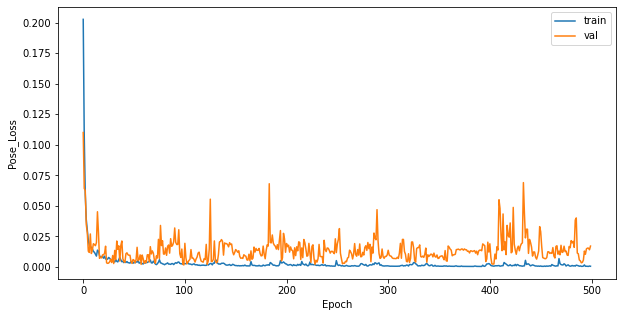

In [15]:
plt.figure(figsize=(10,5))
plt.plot(train_avg_pose_losses, label='train')
plt.plot(val_avg_pose_losses, label='val')
plt.xlabel('Epoch')
plt.ylabel('Pose_Loss')
plt.legend()

# Restore Checkpoint

In [13]:
weight_dict = torch.load(checkpoint_path+'/model-100.pt')

In [14]:
model.load_state_dict(weight_dict)

<All keys matched successfully>

In [15]:
test_image_path = glob("C:/Users/IVCL/Desktop/crane/real_image_crop/*.png")

<ipython-input-10-c6cd387166ba>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,10))


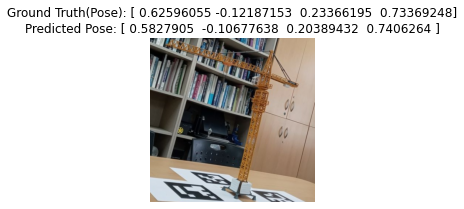

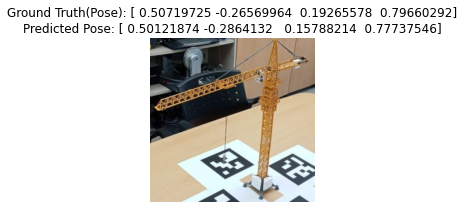

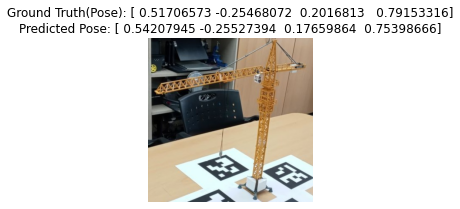

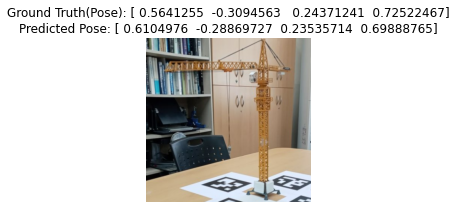

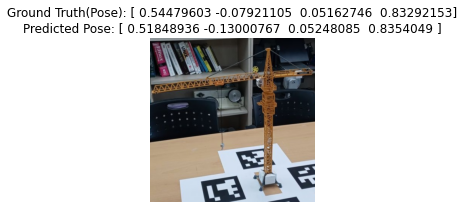

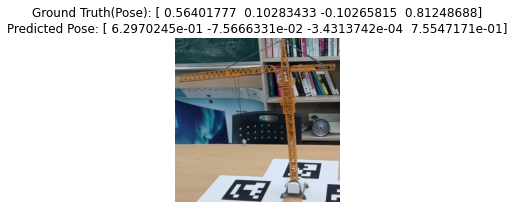

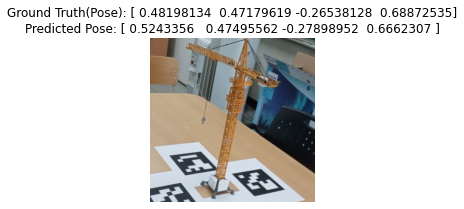

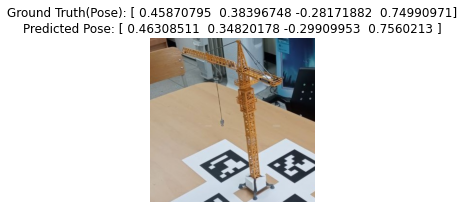

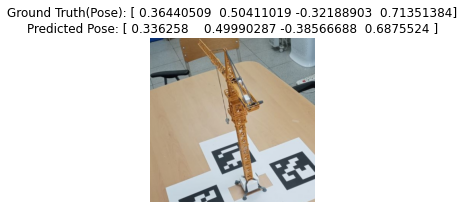

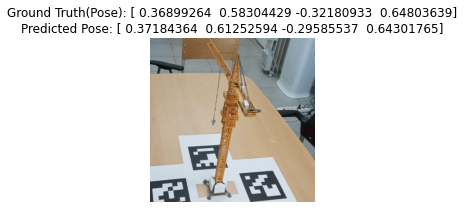

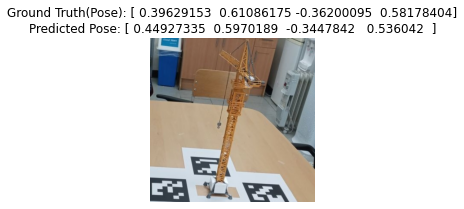

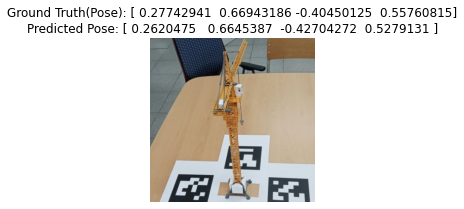

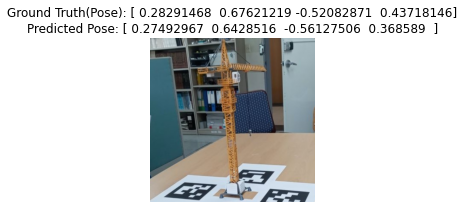

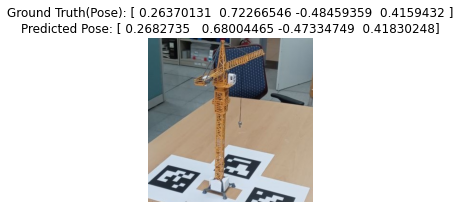

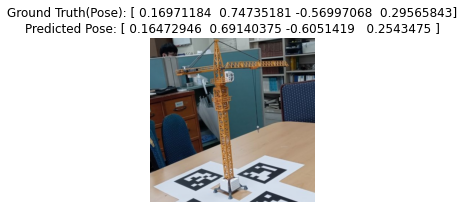

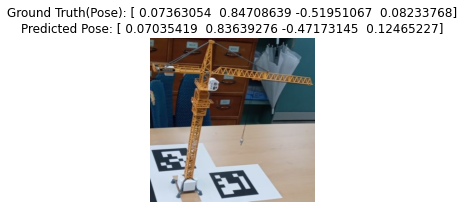

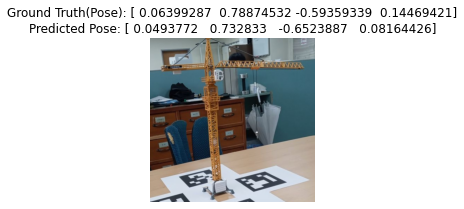

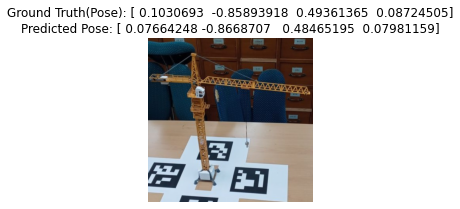

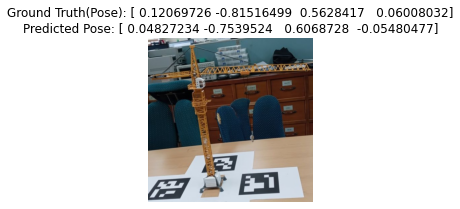

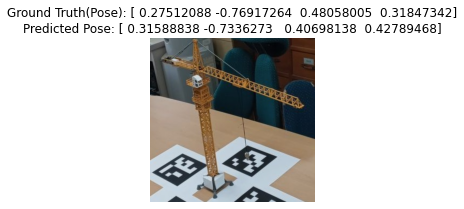

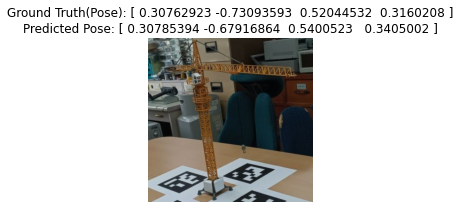

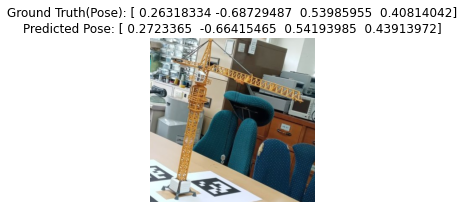

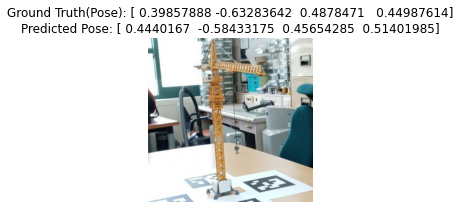

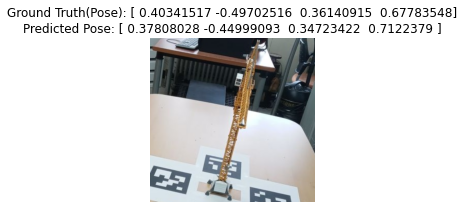

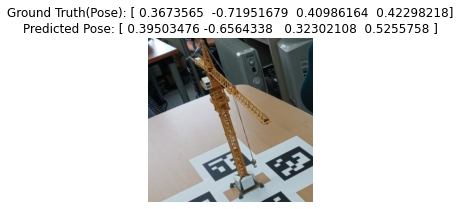

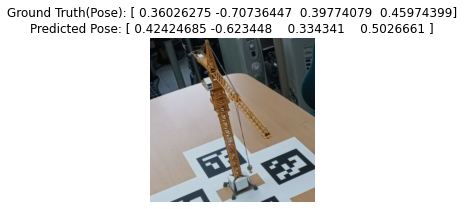

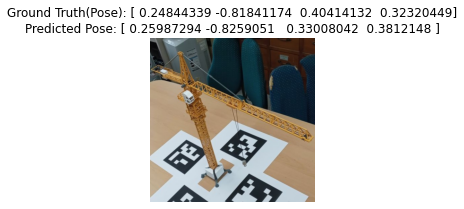

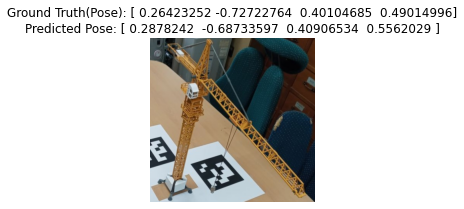

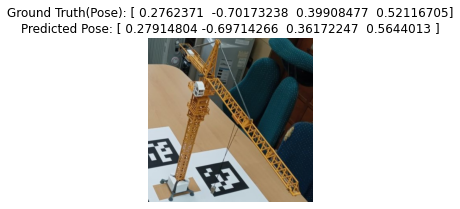

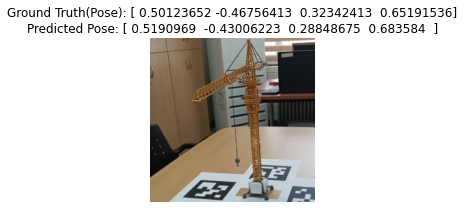

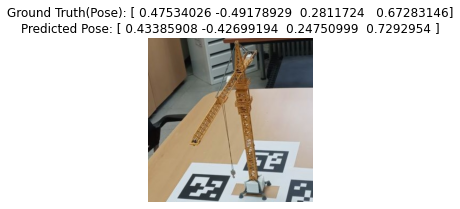

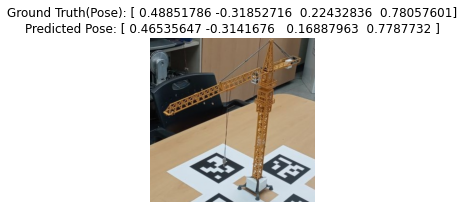

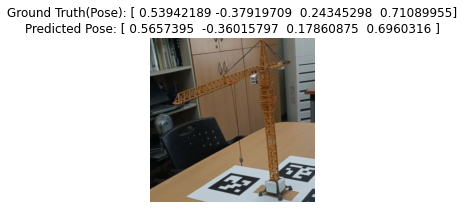

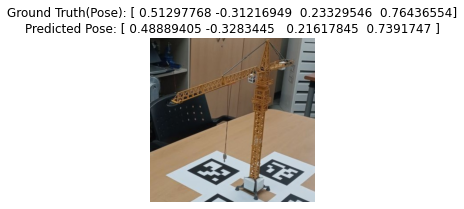

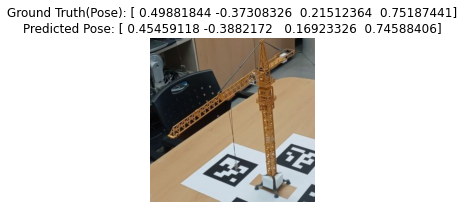

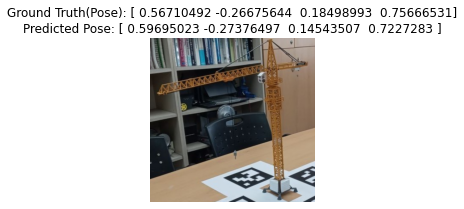

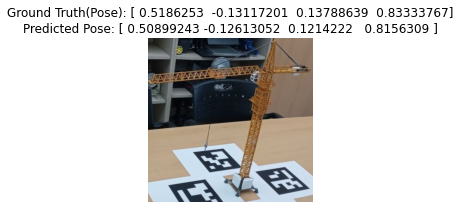

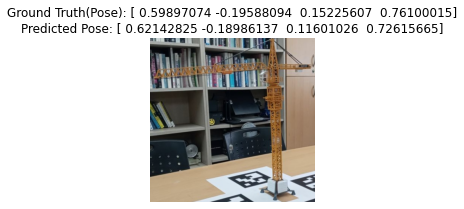

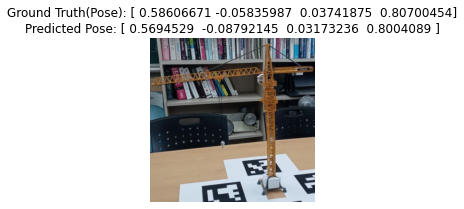

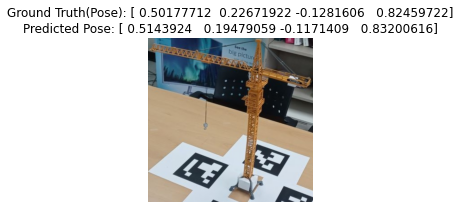

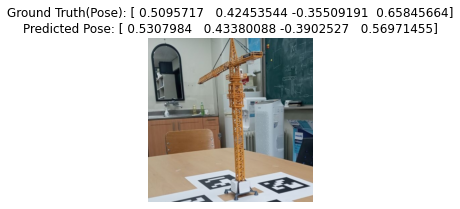

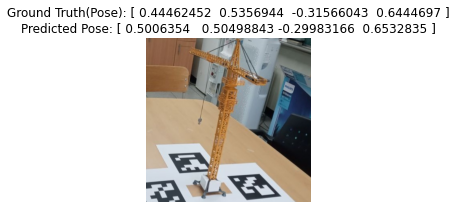

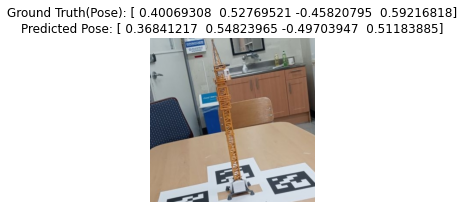

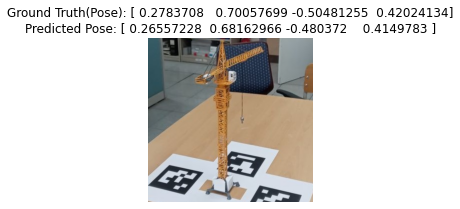

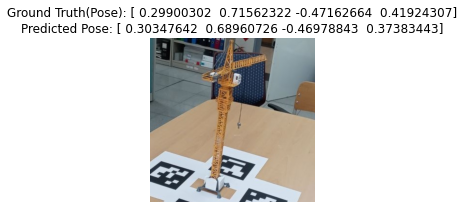

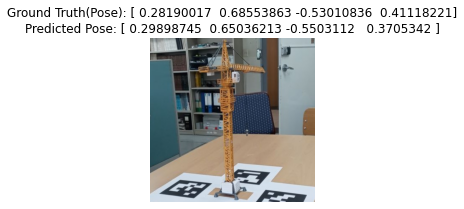

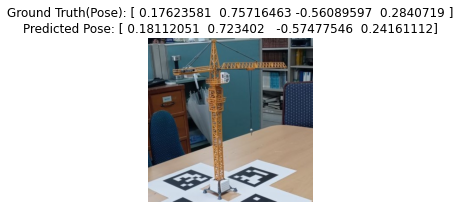

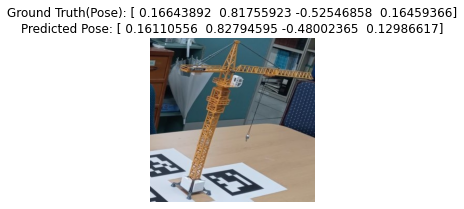

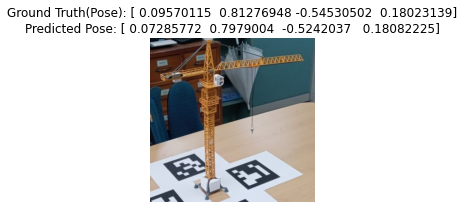

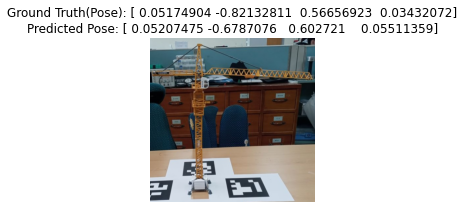

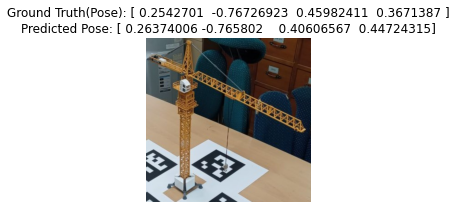

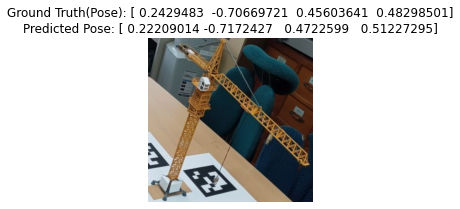

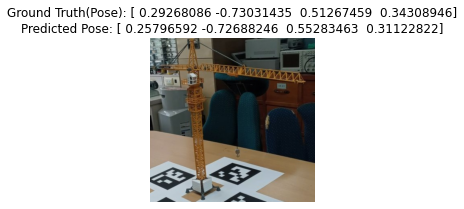

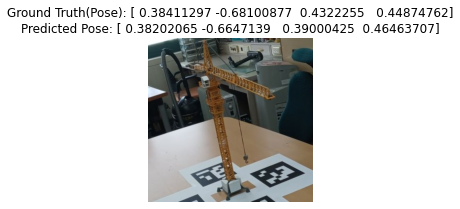

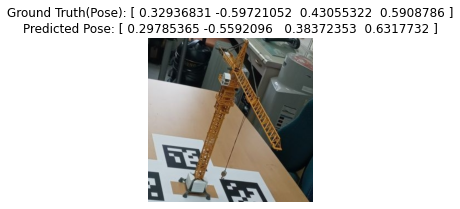

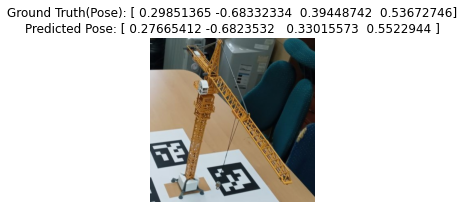

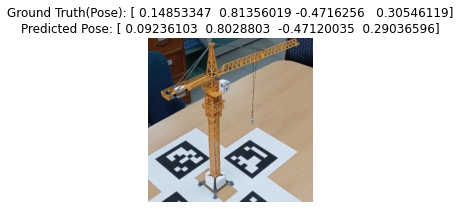

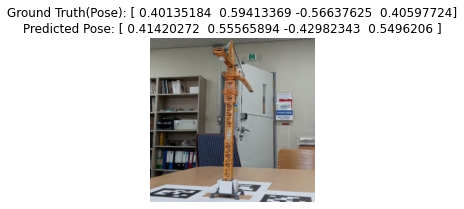

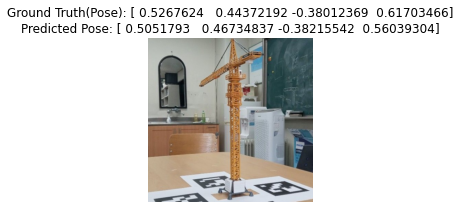

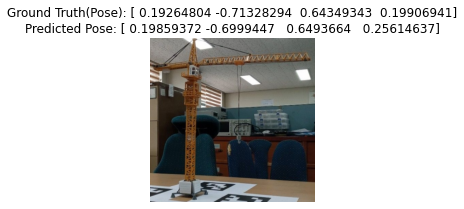

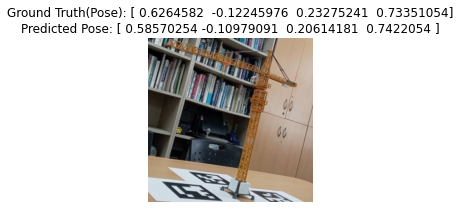

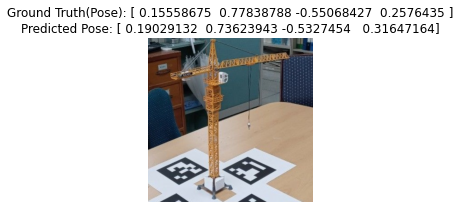

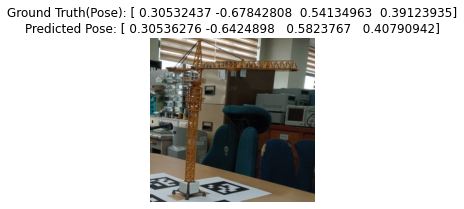

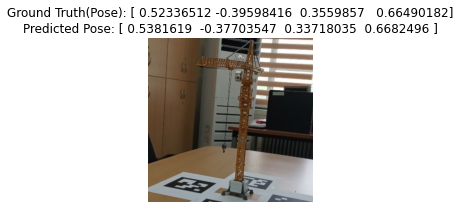

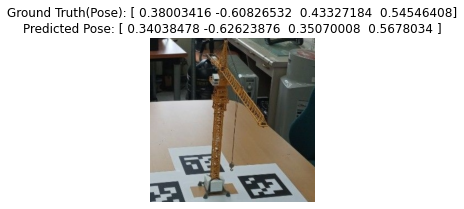

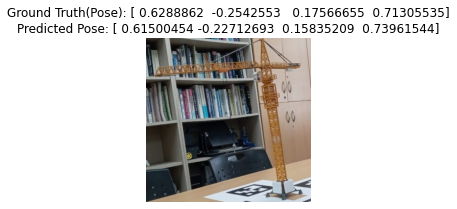

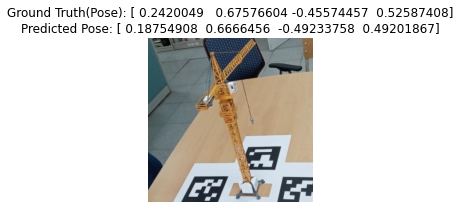

In [16]:
for num in range(len(test_image_path)):
    visualization(model, test_image_path[num], test_pose_list[num])

# Evaluation

In [17]:
pcd = o3d.io.read_point_cloud("crane.ply")
pcd_array = np.asarray(pcd.points)

In [18]:
t_gt = [np.array([[0],[0],[0]]) for i in range(0,len(test_pose_list))]
t_e = [np.array([[0],[0],[0]]) for i in range(0,len(test_pose_list))]

In [19]:
test_pose_list_xyzw = [[test_pose_list[i][1], test_pose_list[i][2], test_pose_list[i][3],
                       test_pose_list[i][0]] for i in range(0, len(test_pose_list))]

In [20]:
R_gt = R.from_quat(test_pose_list_xyzw).as_dcm()

In [21]:
def estimate_pose(model, test_path, test_pose):
    model.eval()
    model.to(device)
    transform = transforms.Compose([
            transforms.Resize(size=(params['input_size'], params['input_size'])),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

    image = Image.open(test_path).convert("RGB")
    image = transform(image).unsqueeze_(0)
    pose = model(image)
    pose = pose[0].cpu().detach().numpy()
    pose = [pose[1], pose[2], pose[3], pose[0]] # wxyz >> xyzw

    return pose

In [22]:
R_e = [R.from_quat(estimate_pose(model, test_image_path[num], test_pose_list[num])).as_dcm()
               for num in range(len(test_image_path))]

In [23]:
accuracy_list = []

for ths in range(0, 101):
    accuracy = 0
    threshold = ths * 0.01
    for num in range(0, len(test_pose_list)):
        accuracy = accuracy + add_ac(R_e[num], t_e[num], R_gt[num], t_gt[num], pcd_array, threshold)
    
    accuracy_list.append(accuracy / len(test_pose_list))

ADD : 0.5551306469057978


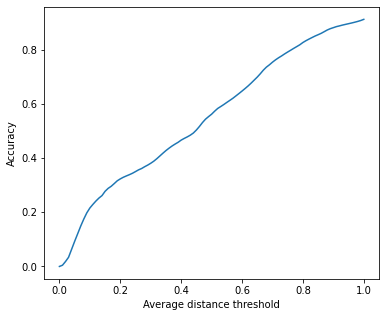

In [24]:
plt.figure(figsize=(6,5))
plt.plot([i*0.01 for i in range(0,101)], accuracy_list)
plt.xlabel("Average distance threshold")
plt.ylabel("Accuracy")

print("ADD :", np.array(accuracy_list).sum() * 0.01)